<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/Anom_detec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pandas_datareader.data as web
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Tensorflow version: 2.3.0


In [2]:
all_data = {ticker : web.get_data_yahoo(ticker)
            for ticker in ['KODK']}
df = pd.DataFrame({ticker : data['Adj Close']
                      for ticker, data in all_data.items()})

df.head()     

,KODK
Date,
2015-10-01,15.46
2015-10-02,15.30
2015-10-05,15.86
2015-10-06,15.93
2015-10-07,16.41


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2015-10-01 to 2020-09-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KODK    1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [4]:
df.tail()

,KODK
Date,
2020-09-22,10.04
2020-09-23,8.93
2020-09-24,8.77
2020-09-25,9.32
2020-09-28,9.31


In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['KODK'], mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [6]:
# split dat into train and test sets

train_size = int(len(df) * 0.8)
test_size = int(len(df) - train_size)

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)


(1005, 1) (252, 1)


In [7]:
# preprocess data
from sklearn.preprocessing import StandardScaler

# instantiate standard scaler

scaler = StandardScaler()

scaler = scaler.fit(train[['KODK']])

train['KODK'] = scaler.transform(train[['KODK']])
test['KODK'] = scaler.transform(test[['KODK']])


In [8]:
def create_sequences(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:(i + time_steps)].values)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys) 

In [9]:
# create time_stamps for 30 days
time_steps = 30

# define x and y train

X_train, y_train = create_sequences(train[['KODK']], train.KODK, time_steps)
X_test, y_test = create_sequences(test[['KODK']], test.KODK, time_steps)




In [10]:
print(X_train.shape)

(975, 30, 1)


In [11]:
# build LSTM auto-econder

timesteps = X_train.shape[1]
num_features = X_train.shape[2]



In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


# create a Sequential model
model = Sequential([
                    LSTM(128, input_shape=(timesteps, num_features)),
                    Dropout(0.2),
                    RepeatVector(timesteps),
                    LSTM(128, return_sequences=True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))
])

model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [13]:
# setup early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')    

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
28/28 [==============================] - 2s 89ms/step - loss: 0.3198 - val_loss: 0.1962
Epoch 2/100
28/28 [==============================] - 2s 66ms/step - loss: 0.2067 - val_loss: 0.0756
Epoch 3/100
28/28 [==============================] - 2s 66ms/step - loss: 0.1457 - val_loss: 0.0925
Epoch 4/100
28/28 [==============================] - 2s 65ms/step - loss: 0.1426 - val_loss: 0.0749
Epoch 5/100
28/28 [==============================] - 2s 65ms/step - loss: 0.2010 - val_loss: 0.1481
Epoch 6/100
28/28 [==============================] - 2s 65ms/step - loss: 0.1138 - val_loss: 0.0477
Epoch 7/100
28/28 [==============================] - 2s 65ms/step - loss: 0.1180 - val_loss: 0.0586
Epoch 8/100
28/28 [==============================] - 2s 66ms/step - loss: 0.1317 - val_loss: 0.0406
Epoch 9/100
28/28 [==============================] - 2s 65ms/step - loss: 0.1453 - val_loss: 0.0584
Epoch 10/100
28/28 [==============================] - 2s 65ms/step - loss: 0.0999 - val_loss: 0.0374

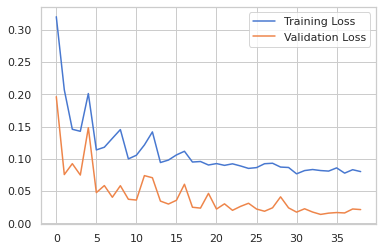

In [15]:
# plot metrics

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label="Validation Loss")

plt.legend();

In [16]:
X_train_pred = model.predict(X_train)

# calculate mean absolute error
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Errors'])

In [17]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 14ms/step - loss: 0.1050


0.1050470620393753

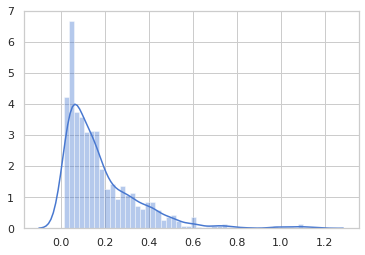

In [18]:
# plot distribution for mae
sns.distplot(train_mae_loss, bins=50, kde=True)

In [20]:
# look at the distplot to set threshold
threshold = 0.8

In [21]:
 # calculate mae on test data
 X_test_pred = model.predict(X_test)
 test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [22]:
# detecting anomalies

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['KODK'] = test[time_steps:].KODK

In [23]:
test_score_df.head()

,KODK,loss,threshold,anomaly
Date,,,,
2019-11-11,-1.142939,0.017760,0.8,False
2019-11-12,-1.159198,0.016384,0.8,False
2019-11-13,-1.167328,0.017954,0.8,False
2019-11-14,-1.177490,0.021043,0.8,False
2019-11-15,-1.161231,0.026296,0.8,False


In [24]:
test_score_df.tail()

,KODK,loss,threshold,anomaly
Date,,,,
2020-09-22,0.385448,0.709271,0.8,False
2020-09-23,0.159848,0.590295,0.8,False
2020-09-24,0.127329,0.430423,0.8,False
2020-09-25,0.239113,0.351487,0.8,False
2020-09-28,0.237080,0.367447,0.8,False


In [28]:
# plot test loss and threshold

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].index, y=test_score_df.loss,
                         mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].index, y=test_score_df.threshold,
                         mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)

In [29]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,KODK,loss,threshold,anomaly
Date,,,,
2020-07-30,4.407624,3.829555,0.8,True
2020-07-31,2.785746,4.583166,0.8,True
2020-08-03,1.381338,4.016987,0.8,True
2020-08-04,1.271586,2.956600,0.8,True
2020-08-05,1.373208,2.318157,0.8,True


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].index, y=scaler.inverse_transform(test[time_steps:].KODK),
                         mode='lines', name='Stock Price'))
fig.add_trace(go.Scatter(x=anomalies.index, y=scaler.inverse_transform(anomalies.KODK),
                         mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()